In [47]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import unicodedata

BASE_PATH = Path(".")  # notebook is at root

In [48]:
def load_activity_df(folder_name, activity_label):
    dfs = []
    folder_path = BASE_PATH / folder_name

    for csv_file in folder_path.glob("*.csv"):
        df = pd.read_csv(csv_file)

        df["activity_type"] = activity_label
        df["source_file"] = csv_file.name

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


## Loading UIDAI datasets

Here we load all UIDAI CSV files for enrolment, demographic updates, and biometric updates.
Each activity type is kept in a separate dataframe to avoid mixing concepts early on.

This separation helps later when comparing how enrolments differ from update behaviour.

In [49]:
enrolment_df = load_activity_df(
    "api_data_aadhar_enrolment",
    "enrolment"
)

demographic_df = load_activity_df(
    "api_data_aadhar_demographic",
    "demographic_update"
)

biometric_df = load_activity_df(
    "api_data_aadhar_biometric",
    "biometric_update"
)


## Missing data check

We check for missing values across all three datasets.
Surprisingly, there are **no missing values** in the raw data.

This means the main data quality issue is not missing entries, but **inconsistent naming and mapping**, especially for states.

In [50]:
def normalize_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

enrolment_df = normalize_columns(enrolment_df)
demographic_df = normalize_columns(demographic_df)
biometric_df = normalize_columns(biometric_df)

In [51]:
enrolment_df.isna().sum().sort_values(ascending=False) # 0 missing data

date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
activity_type     0
source_file       0
dtype: int64

In [52]:
demographic_df.isna().sum().sort_values(ascending=False) # 0 missing data

date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
activity_type    0
source_file      0
dtype: int64

In [53]:
biometric_df.isna().sum().sort_values(ascending=False) # 0 missing data

date             0
state            0
district         0
pincode          0
bio_age_5_17     0
bio_age_17_      0
activity_type    0
source_file      0
dtype: int64

## Checking state name consistency

Although there are no missing values, state names can still be inconsistent.
The same state may appear under multiple spellings, casing styles, or legacy names.

This step identifies whether such variations exist and how bad the problem actually is.

In [54]:
# checking if state names are unique or there are multiple different form of entries for same state

states_enrol = set(enrolment_df["state"].unique())
states_demo = set(demographic_df["state"].unique())
states_bio = set(biometric_df["state"].unique())

# states_enrol

## Cleaning and normalizing state names

Multiple variants of the same state name are observed (for example Odisha / Orissa, West Bengal with casing and spelling issues).

To fix this, a **canonical state mapping** is created so that every variation maps to a single standard state name.
This ensures reliable grouping and comparison later.

In [55]:
# cleaning the found states with bad state name entries

def drop_numeric_states(df): # removing purely numeric state name rows
    df = df[~df["state"].str.fullmatch(r"\d+", na=False)]
    return df

enrolment_df = drop_numeric_states(enrolment_df)
demographic_df = drop_numeric_states(demographic_df)
biometric_df = drop_numeric_states(biometric_df)

def basic_state_cleanup(df): # basic state string cleanup
    df["state"] = (
        df["state"]
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
        .str.title()
    )
    return df

enrolment_df = basic_state_cleanup(enrolment_df)
demographic_df = basic_state_cleanup(demographic_df)
biometric_df = basic_state_cleanup(biometric_df)

## Handling city-level leakage in state column

While cleaning state names, a small number of **city / locality names** appear in the state column,
mainly in the demographic update dataset.
These are then stored into the dictionary

Policy used here:
- If the number of such city entries is **small (≤ 10)**, they are mapped to their correct states.
- If this number were large, they would be frozen and excluded to avoid incorrect assumptions.

This avoids unnecessary data loss while keeping the logic explicit and controlled.

In [56]:
# creating a map for states with multiple state name entries
# created map MANUALLY as the number of states is less and can be done easily unlike districts
# NOTE ALSO MAPPED THE CITY NAMES TO STATES MANUALLY

# POLICY:
# If city/locality leakage in 'state' column is <= 10 distinct values,
# we map them to their correct states to avoid data loss.
# If leakage > 10, such rows are frozen and excluded from state-level analysis.

STATE_CANONICAL_MAP = {

    "Andaman & Nicobar Islands": "Andaman And Nicobar Islands",
    "Andaman and Nicobar Islands": "Andaman And Nicobar Islands",
    "Andaman And Nicobar": "Andaman And Nicobar Islands",

    "Andhra Pradesh": "Andhra Pradesh",
    "andhra pradesh": "Andhra Pradesh",

    "Arunachal Pradesh": "Arunachal Pradesh",

    "Assam": "Assam",

    "Bihar": "Bihar",

    "Chandigarh": "Chandigarh",

    "Chhatisgarh": "Chhattisgarh",
    "Chhattisgarh": "Chhattisgarh",

    "Dadra & Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra and Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra and Nagar Haveli and Daman and Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman & Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman and Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra And Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "The Dadra And Nagar Haveli And Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra And Nagar Haveli And Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra And Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",

    "Delhi": "Delhi",

    "Goa": "Goa",

    "Gujarat": "Gujarat",

    "Haryana": "Haryana",

    "Himachal Pradesh": "Himachal Pradesh",

    "Jammu & Kashmir": "Jammu And Kashmir",
    "Jammu and Kashmir": "Jammu And Kashmir",

    "Jharkhand": "Jharkhand",

    "Karnataka": "Karnataka",

    "Kerala": "Kerala",

    "Ladakh": "Ladakh",

    "Lakshadweep": "Lakshadweep",

    "Madhya Pradesh": "Madhya Pradesh",

    "Maharashtra": "Maharashtra",

    "Manipur": "Manipur",

    "Meghalaya": "Meghalaya",

    "Mizoram": "Mizoram",

    "Nagaland": "Nagaland",

    "ODISHA": "Odisha",
    "Odisha": "Odisha",
    "Orissa": "Odisha",
    "odisha": "Odisha",

    "Pondicherry": "Puducherry",
    "Puducherry": "Puducherry",

    "Punjab": "Punjab",

    "Rajasthan": "Rajasthan",

    "Sikkim": "Sikkim",

    "Tamil Nadu": "Tamil Nadu",
    "Tamilnadu": "Tamil Nadu",

    "Telangana": "Telangana",

    "Tripura": "Tripura",

    "Uttar Pradesh": "Uttar Pradesh",

    "Uttarakhand": "Uttarakhand",
    "Uttaranchal": "Uttarakhand",

    "WEST BENGAL": "West Bengal",
    "WESTBENGAL": "West Bengal",
    "West  Bengal": "West Bengal",
    "West Bangal": "West Bengal",
    "West Bengal": "West Bengal",
    "West bengal": "West Bengal",
    "Westbengal": "West Bengal",
    "west Bengal": "West Bengal",
    "West Bengli": "West Bengal",

    #city maps
    "Darbhanga": "Bihar",
    "Balanagar": "Telangana",
    "Jaipur": "Rajasthan",
    "Madanapalle": "Andhra Pradesh",
    "Puttenahalli": "Karnataka",
    "Nagpur": "Maharashtra",
    "Raja Annamalai Puram": "Tamil Nadu"
}
CANONICAL_STATES = {
    "Andaman And Nicobar Islands",
    "Andhra Pradesh",
    "Arunachal Pradesh",
    "Assam",
    "Bihar",
    "Chandigarh",
    "Chhattisgarh",
    "Dadra And Nagar Haveli And Daman And Diu",
    "Delhi",
    "Goa",
    "Gujarat",
    "Haryana",
    "Himachal Pradesh",
    "Jammu And Kashmir",
    "Jharkhand",
    "Karnataka",
    "Kerala",
    "Ladakh",
    "Lakshadweep",
    "Madhya Pradesh",
    "Maharashtra",
    "Manipur",
    "Meghalaya",
    "Mizoram",
    "Nagaland",
    "Odisha",
    "Puducherry",
    "Punjab",
    "Rajasthan",
    "Sikkim",
    "Tamil Nadu",
    "Telangana",
    "Tripura",
    "Uttar Pradesh",
    "Uttarakhand",
    "West Bengal"
}


def apply_state_map(df): # applying state map to dataframes
    df["state"] = df["state"].replace(STATE_CANONICAL_MAP)
    return df

enrolment_df = apply_state_map(enrolment_df)
demographic_df = apply_state_map(demographic_df)
biometric_df = apply_state_map(biometric_df)

def validate_states(df, name):
    invalid = df.loc[~df["state"].isin(CANONICAL_STATES), "state"]
    print(f"\n{name} — invalid state values:")
    print(invalid.value_counts())
    return invalid


validate_states(enrolment_df, "ENROLMENT")
validate_states(demographic_df, "DEMOGRAPHIC")
validate_states(biometric_df, "BIOMETRIC")

demographic_df["is_valid_state"] = demographic_df["state"].isin(CANONICAL_STATES)
demo_clean = demographic_df[demographic_df["is_valid_state"]]
demo_invalid = demographic_df[~demographic_df["is_valid_state"]]


ENROLMENT — invalid state values:
Series([], Name: count, dtype: int64)

DEMOGRAPHIC — invalid state values:
Series([], Name: count, dtype: int64)

BIOMETRIC — invalid state values:
Series([], Name: count, dtype: int64)


### Before creating the chorolepth, reading the geojson map file and cleaning state names in it
Cleaned names stored back into `STATE_CANONICAL_MAP`

## Creating state-wise summary tables

The data is now aggregated at the state level.
For each state, we compute:
- total enrolments
- total demographic updates
- total biometric updates

This gives a compact representation of Aadhaar activity per state.

## Update pressure metric

Update pressure is defined as:

(demographic updates + biometric updates) / enrolments

This tells us **how many Aadhaar updates occur per new enrolment** in each state.
It helps compare states fairly by normalizing update activity against enrolment volume.

In [57]:
# using mapIndia.json file to draw a chorolepth 
india_gdf = gpd.read_file("mapIndia.json")
india_gdf = india_gdf.rename(columns={"name": "state"}) # assigning "name" col to "state"

# cleaning mapIndia.json state names
india_gdf["state"] = (
    india_gdf["state"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.title()
)

def strip_accents(text):
    if not isinstance(text, str):
        return text
    return "".join(
        c for c in unicodedata.normalize("NFKD", text)
        if not unicodedata.combining(c)
    )

india_gdf["state"] = india_gdf["state"].replace(STATE_CANONICAL_MAP)
india_gdf["state"] = india_gdf["state"].apply(strip_accents)



# set(india_gdf["state"]) - CANONICAL_STATES # checking for discripencies, none found

# making data -> statewise data for efficiency
state_enrol = enrolment_df.groupby("state").size().rename("enrolments")
state_demo  = demographic_df.groupby("state").size().rename("demographic_updates")
state_bio   = biometric_df.groupby("state").size().rename("biometric_updates")

state_summary = (
    state_enrol.to_frame()
    .join(state_demo, how="left")
    .join(state_bio, how="left")
    .fillna(0)
)

india_summary_gdf = india_gdf.merge(
    state_summary.reset_index(),
    on="state",
    how="left"
)

## Mapping update pressure across India

The state-wise update pressure values are merged with Indian state boundaries
and visualized as a choropleth map.

Darker regions indicate higher Aadhaar maintenance activity relative to new enrolments.


## Baseline Spatial Distribution of Aadhaar Activity

Before applying any normalized metrics, we visualise the raw spatial distribution
of Aadhaar enrolments, demographic updates, and biometric updates across Indian states.
These maps act as baseline context and motivate the use of ratio-based analysis later.


(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

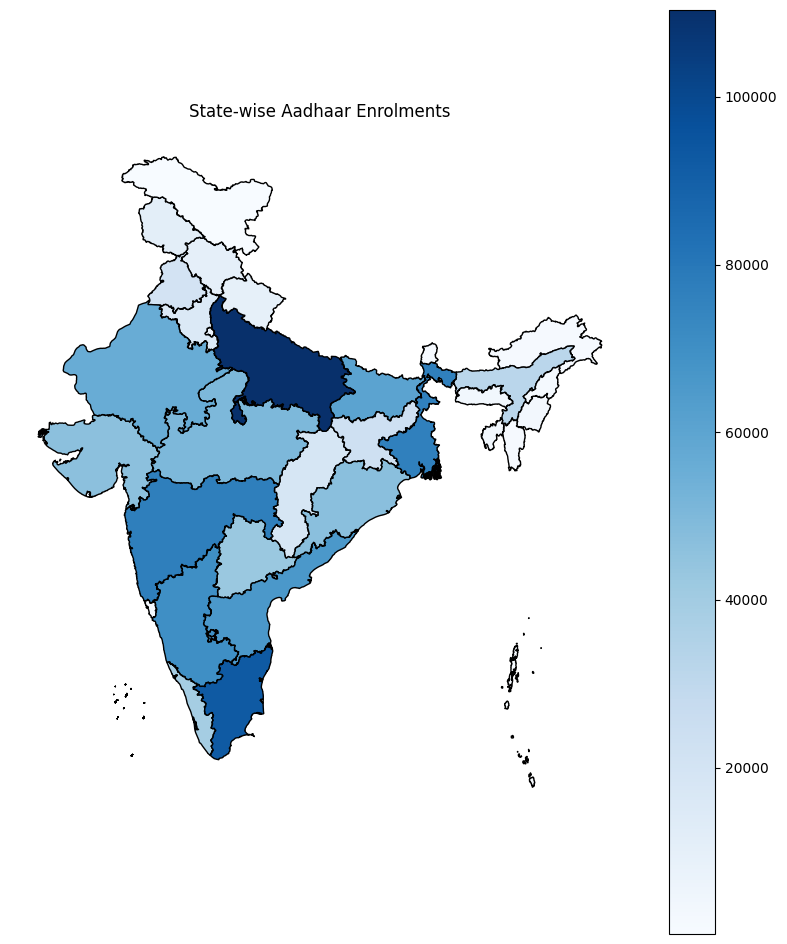

In [58]:
# BASE MAP 1: ENROLMENTS
# shows where new Aadhaar creation is happening

ax = india_summary_gdf.plot(
    column="enrolments",
    cmap="Blues",
    legend=True,
    figsize=(10, 12),
    edgecolor="black"
)
ax.set_title("State-wise Aadhaar Enrolments")
ax.axis("off")

(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

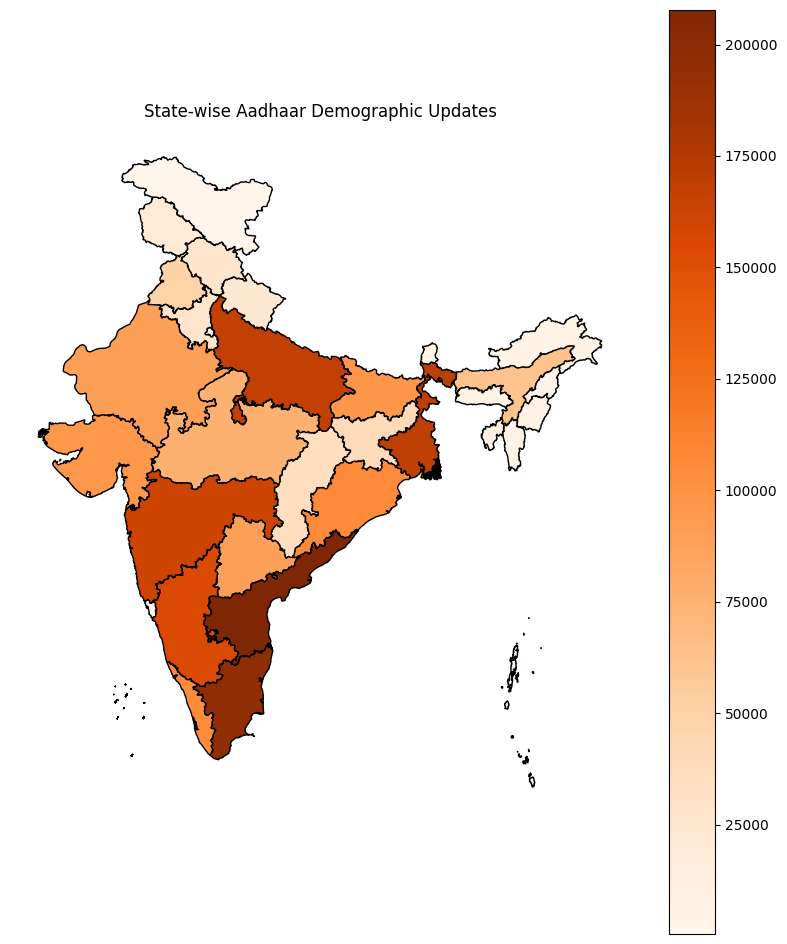

In [59]:
# BASE MAP 2: DEMOGRAPHIC UPDATES
# shows where address / name / dob updates dominate

ax = india_summary_gdf.plot(
    column="demographic_updates",
    cmap="Oranges",
    legend=True,
    figsize=(10, 12),
    edgecolor="black"
)
ax.set_title("State-wise Aadhaar Demographic Updates")
ax.axis("off")


(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

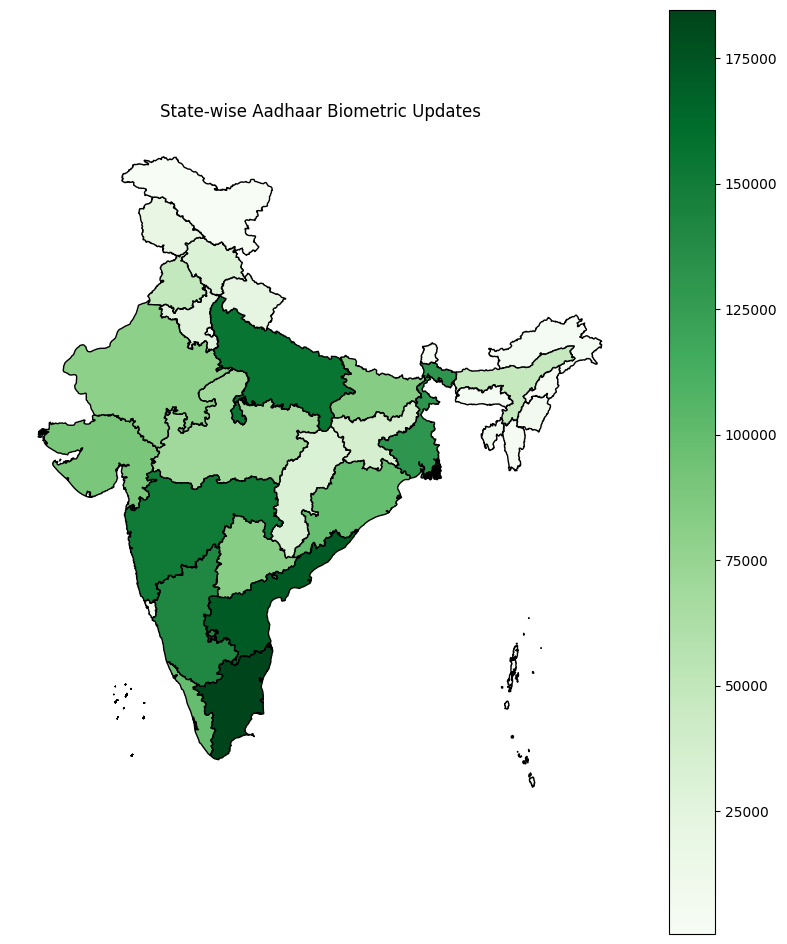

In [60]:

# BASE MAP 3: BIOMETRIC UPDATES
# shows where biometric corrections are frequent

ax = india_summary_gdf.plot(
    column="biometric_updates",
    cmap="Greens",
    legend=True,
    figsize=(10, 12),
    edgecolor="black"
)
ax.set_title("State-wise Aadhaar Biometric Updates")
ax.axis("off")


## Normalized Aadhaar Metrics (State-wise)

The following maps visualise normalized metrics derived from enrolments and updates.
These allow fair comparison across states by accounting for differences in scale.


(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

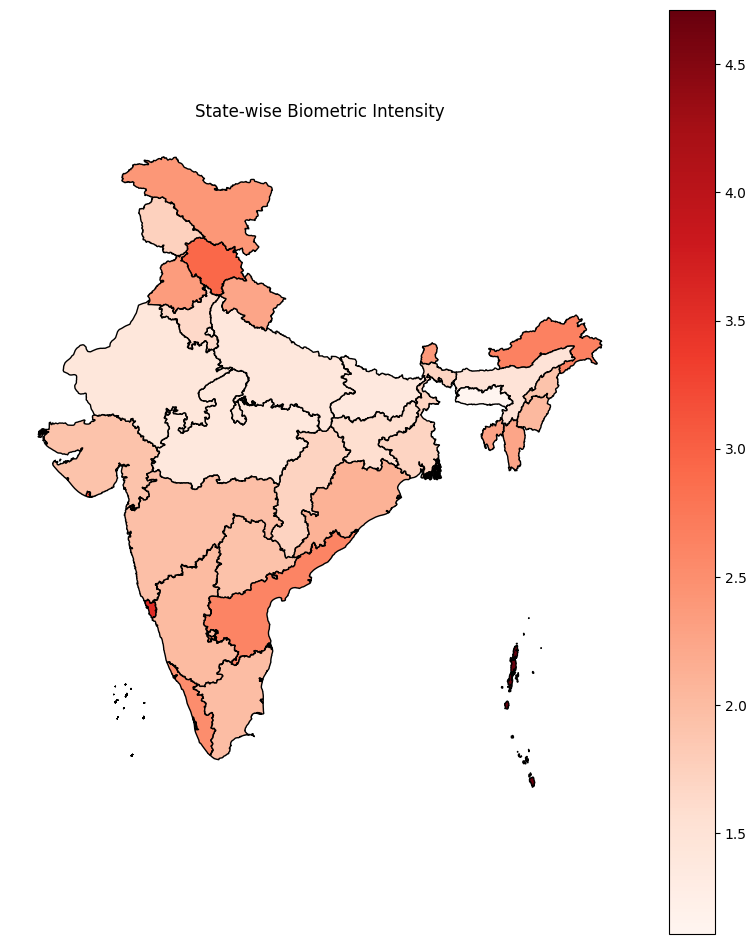

In [61]:

# BIOMETRIC INTENSITY
# biometric updates per enrolment

state_summary["biometric_intensity"] = (
    state_summary["biometric_updates"] / state_summary["enrolments"]
)

ax = india_summary_gdf.merge(
    state_summary.reset_index(),
    on="state",
    how="left"
).plot(
    column="biometric_intensity",
    cmap="Reds",
    legend=True,
    figsize=(10, 12),
    edgecolor="black"
)
ax.set_title("State-wise Biometric Intensity")
ax.axis("off")

(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

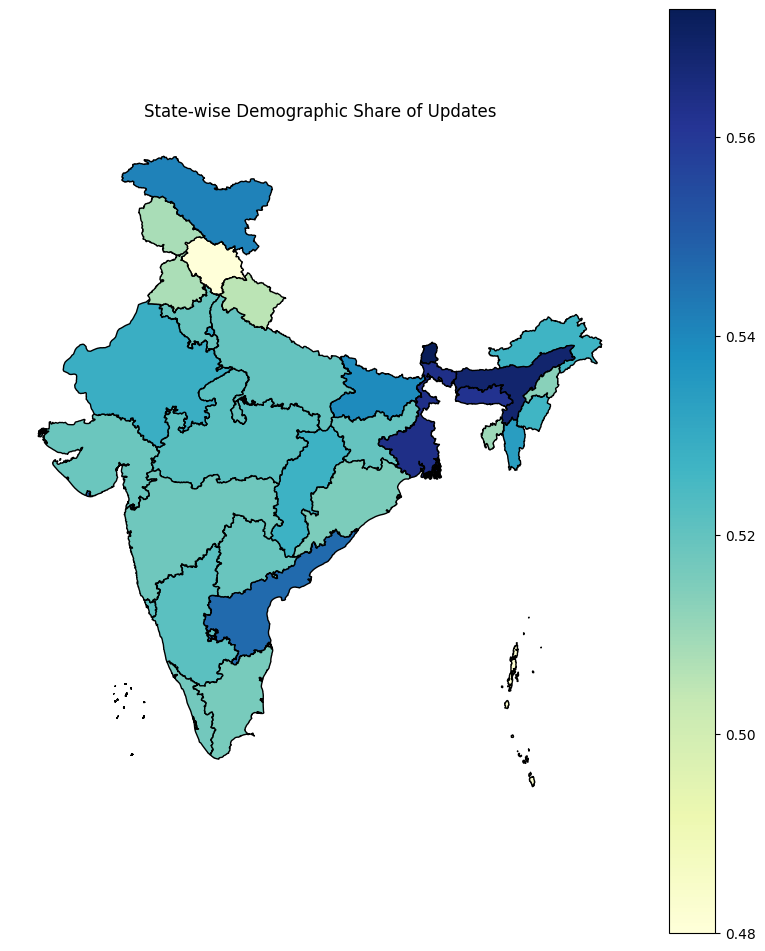

In [62]:

# DEMOGRAPHIC SHARE
# fraction of updates that are demographic

state_summary["demographic_share"] = (
    state_summary["demographic_updates"]
    / (state_summary["demographic_updates"] + state_summary["biometric_updates"])
)

ax = india_summary_gdf.merge(
    state_summary.reset_index(),
    on="state",
    how="left"
).plot(
    column="demographic_share",
    cmap="YlGnBu",
    legend=True,
    figsize=(10, 12),
    edgecolor="black"
)
ax.set_title("State-wise Demographic Share of Updates")
ax.axis("off")

(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

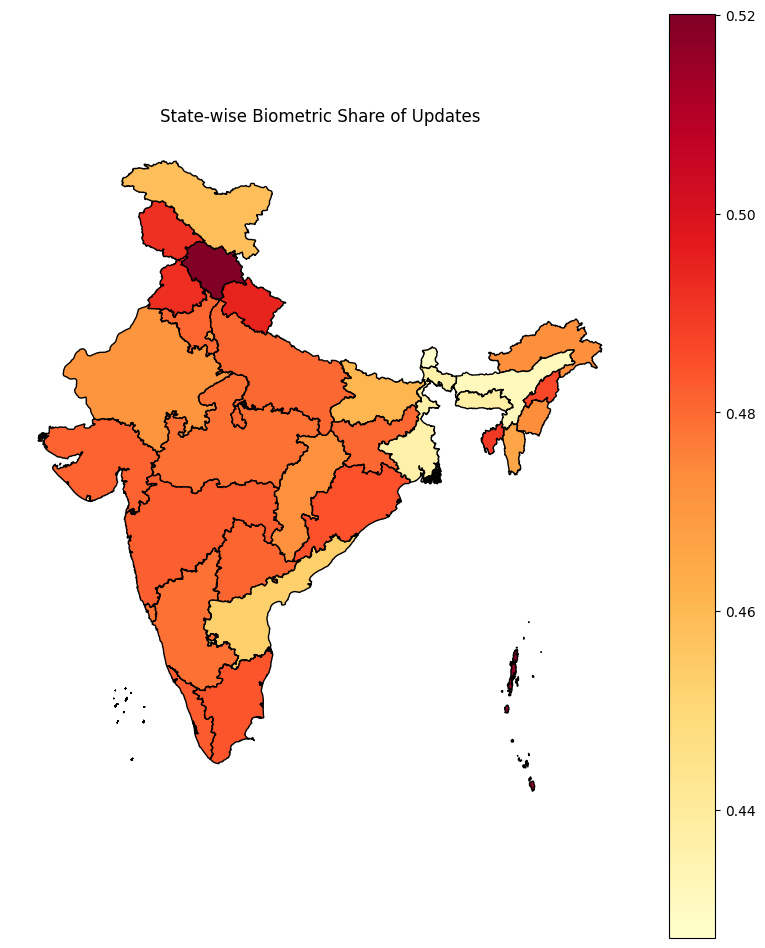

In [63]:

# BIOMETRIC SHARE
# inverse of demographic share

state_summary["biometric_share"] = (
    state_summary["biometric_updates"]
    / (state_summary["demographic_updates"] + state_summary["biometric_updates"])
)

ax = india_summary_gdf.merge(
    state_summary.reset_index(),
    on="state",
    how="left"
).plot(
    column="biometric_share",
    cmap="YlOrRd",
    legend=True,
    figsize=(10, 12),
    edgecolor="black"
)
ax.set_title("State-wise Biometric Share of Updates")
ax.axis("off")

(np.float64(66.72497978912614),
 np.float64(98.87289772366783),
 np.float64(5.238055188164617),
 np.float64(38.59446876503417))

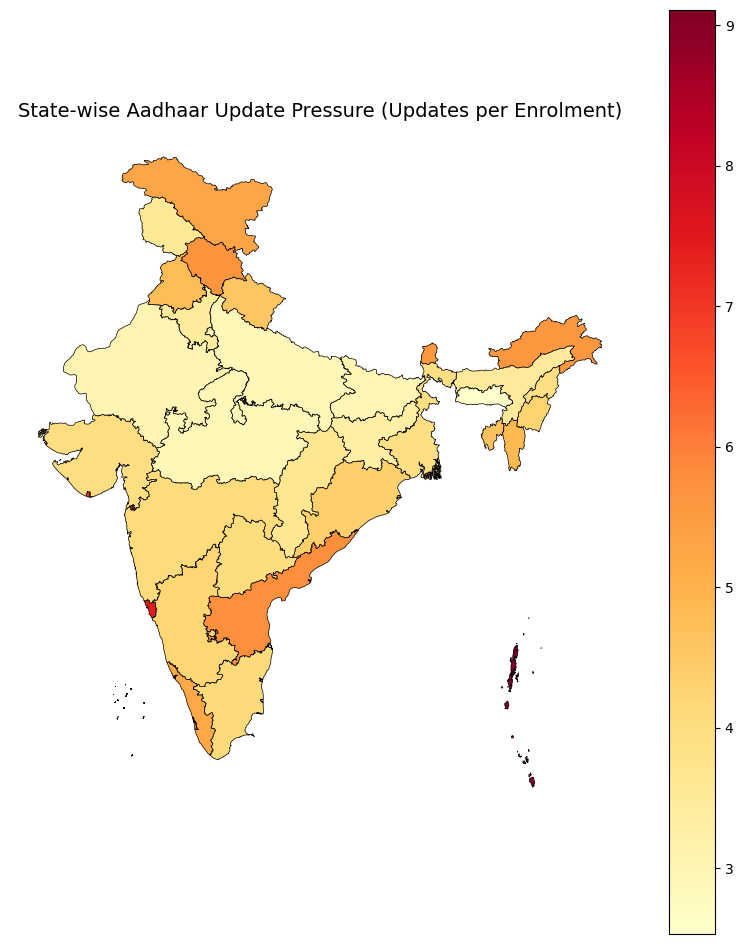

In [64]:
# finding update pressure for every state
# HERE UPDATE PRESSURE GIVES US HOW MANY NEW UPDATES TAKE PLACE PER ENROLLMENT
# ALSO NEW UPDATES = DEMO UPDATES + BIO UPDATES!!
state_summary["update_pressure"] = (
    (state_summary["demographic_updates"] + state_summary["biometric_updates"])
    / state_summary["enrolments"]
)

india_summary_gdf = india_summary_gdf.merge(
    state_summary[["update_pressure"]],
    left_on="state",
    right_index=True,
    how="left"
)

ax = india_summary_gdf.plot(
    column="update_pressure",
    cmap="YlOrRd",
    legend=True,
    figsize=(10, 12),
    edgecolor="black",
    linewidth=0.5
)

ax.set_title(
    "State-wise Aadhaar Update Pressure (Updates per Enrolment)",
    fontsize=14
)
ax.axis("off")


## Outlier State Detection

States that deviate strongly from national Aadhaar behaviour
are identified using z-scores on update pressure.


In [65]:

# OUTLIER STATES BASED ON UPDATE PRESSURE

state_summary["pressure_zscore"] = (
    (state_summary["update_pressure"] - state_summary["update_pressure"].mean())
    / state_summary["update_pressure"].std()
)

state_summary.loc[
    state_summary["pressure_zscore"].abs() > 2,
    ["update_pressure", "pressure_zscore"]
].sort_values("pressure_zscore", ascending=False)


,update_pressure,pressure_zscore
state,,
Andaman And Nicobar Islands,9.109694,3.194896
Goa,7.432220,2.022072


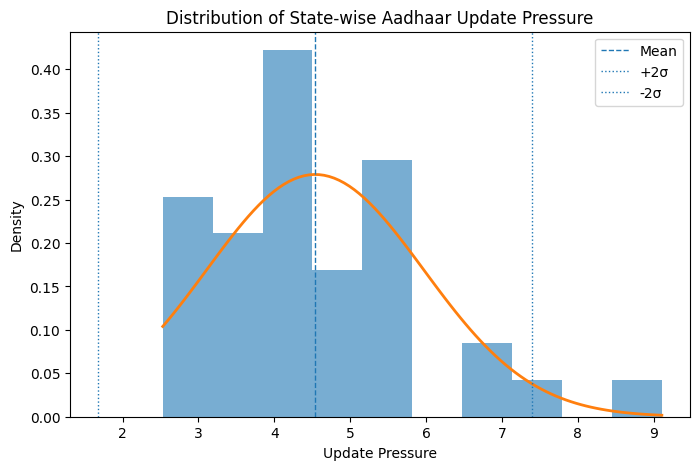

In [66]:
import matplotlib.pyplot as plt
import numpy as np


pressure = state_summary["update_pressure"]
plt.figure(figsize=(8, 5))

plt.hist(
    pressure,
    bins=10,
    density=True,
    alpha=0.6
)

mu = pressure.mean()
sigma = pressure.std()

x = np.linspace(pressure.min(), pressure.max(), 100)

normal_curve = (
    1 / (sigma * np.sqrt(2 * np.pi))
    * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
)

plt.plot(x, normal_curve, linewidth=2)

plt.axvline(mu, linestyle="--", linewidth=1, label="Mean")

plt.axvline(mu + 2*sigma, linestyle=":", linewidth=1, label="+2σ")
plt.axvline(mu - 2*sigma, linestyle=":", linewidth=1, label="-2σ")

plt.title("Distribution of State-wise Aadhaar Update Pressure")
plt.xlabel("Update Pressure")
plt.ylabel("Density")
plt.legend()
plt.show()

